##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Sparse weights using structural pruning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_sparsity_2_by_4"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_sparsity_2_by_4.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_sparsity_2_by_4.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/model-optimization/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_sparsity_2_by_4.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Structural pruning weights from your model to make it sparse in specific pattern can accelerate model inference time with appropriate HW supports.

This tutorial shows you how to:
* Define and train a model on the mnist dataset with a specific structural sparsity
* Convert the pruned model to tflite format
* Visualize structure of the pruned weights

For a general overview of the pruning technique for the model optimization, see the [pruning overview](https://www.tensorflow.org/model_optimization/guide/pruning). For tutorial on general weight pruning, see [Pruning in Keras](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras).

## Structural pruning of weights

Structural pruning systematically zeroes out model weights at the beginning of the training process. You apply this pruning techniques to regular blocks of weights to speed up inference on supporting HWs, for example: grouping weights in the model by blocks of four and zeroing out two of those weights in each block, known as a _2 by 4_ reduction. This technique applies only to the last dimension of the weight tensor for the model that is converted by TensorFlow Lite. For example, `Conv2D` layer weights in TensorFlow Lite have the structure `[channel_out, height, width, channel_in]` and `Dense` layer weights have the structure `[channel_out, channel_in]`. The sparsity pattern is applied to the weights in the last dimension: `channel_in`.

Compare to the random sparsity, the structured sparsity generally has lower accuracy due to restrictive structure, however, it can reduce inference time significantly on the supported hardware.

Pruning can be applied to a model together with other model compression techniques for better compression rate. See quantization and clustering examples in [collaborative optimization technique](https://blog.tensorflow.org/2021/10/Collaborative-Optimizations.html) for more details.

## Setup

Prepare your development environment and data.

In [2]:
! pip install -q tensorflow
! pip install -q tensorflow-model-optimization
! pip install -q matplotlib

In [3]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

2025-06-21 11:29:52.922961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750505392.944354   24882 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750505392.950893   24882 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750505392.968012   24882 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750505392.968035   24882 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750505392.968037   24882 computation_placer.cc:177] computation placer alr

## Download and normalize image data from the [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) dataset

In [4]:
# Load MNIST dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

## Define structural pruning parameters

Define parameters for pruning and specify the type of structural pruning. Set the parameters for pruning to `(2, 4)`.
These settings mean that in a block of four elements, at least two with the lowest magnitude are set to zero.

You don't have to set the `pruning_schedule` parameter. By default, the pruning mask is defined at the first step and it is not updated during the training.

In [5]:
pruning_params_2_by_4 = {
    'sparsity_m_by_n': (2, 4),
}

Define parameters for random pruning with the target sparsity of 50%.

In [6]:
pruning_params_sparsity_0_5 = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5,
                                                              begin_step=0,
                                                              frequency=100)
}

Define the model architecture and specify which layers to prune. Structural pruning is applied based on the layers of the model you select.

In the example below, we prune only some of the layers. We prune the second `Conv2D` layer and the first `Dense` layer.

Notice that the first `Conv2D` layer cannot be pruned structurally. To be pruned structurally, it should have more than one input channels. Instead, we prune the first `Conv2D` layer with random pruning.

In [7]:
model = keras.Sequential([
    prune_low_magnitude(
        keras.layers.Conv2D(
            32, 5, padding='same', activation='relu',
            input_shape=(28, 28, 1),
            name="pruning_sparsity_0_5"),
        **pruning_params_sparsity_0_5),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    prune_low_magnitude(
        keras.layers.Conv2D(
            64, 5, padding='same',
            name="structural_pruning"),
        **pruning_params_2_by_4),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    keras.layers.Flatten(),
    prune_low_magnitude(
        keras.layers.Dense(
            1024, activation='relu',
            name="structural_pruning_dense"),
        **pruning_params_2_by_4),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

2025-06-21 11:29:56.776140: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 prune_low_magnitude_prunin  (None, 28, 28, 32)        1634      


 g_sparsity_0_5 (PruneLowMa                                      


 gnitude)                                                        


 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         


 D)                                                              


 prune_low_magnitude_struct  (None, 14, 14, 64)        102466    


 ural_pruning (PruneLowMagn                                      


 itude)                                                          


 batch_normalization (Batch  (None, 14, 14, 64)        256       


 Normalization)                                                  


 re_lu (ReLU)                (None, 14, 14, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         


 g2D)                                                            


 flatten (Flatten)           (None, 3136)              0         


 prune_low_magnitude_struct  (None, 1024)              6423554   


 ural_pruning_dense (PruneL                                      


 owMagnitude)                                                    


 dropout (Dropout)           (None, 1024)              0         


 dense (Dense)               (None, 10)                10250     


Total params: 6538160 (24.94 MB)


Trainable params: 3274762 (12.49 MB)


Non-trainable params: 3263398 (12.45 MB)


_________________________________________________________________


Train and evaluate the model.

In [8]:
batch_size = 128
epochs = 2

model.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks=tfmot.sparsity.keras.UpdatePruningStep(),
    validation_split=0.1)

_, pruned_model_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print('Pruned test accuracy:', pruned_model_accuracy)

Pruned test accuracy: 0.9865999817848206


Remove the pruning wrapper so that it is not included in the model when you convert it to TensorFlow Lite format.

In [9]:
model = tfmot.sparsity.keras.strip_pruning(model)

## Convert model to tflite format

In [10]:
import tempfile

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

_, tflite_file = tempfile.mkstemp('.tflite')
print('Saved converted pruned model to:', tflite_file)
with open(tflite_file, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpvliqo0lw/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpvliqo0lw/assets


Saved converted pruned model to: /tmpfs/tmp/tmpr4fup215.tflite


W0000 00:00:1750505432.319830   24882 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750505432.319870   24882 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1750505432.328462   24882 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


## Visualize and check weights

Now visualize the structure of weights in the `Dense` layer pruned with 2 by 4 sparsity. Extract the weights from the tflite file.

In [11]:
# Load tflite file with the created pruned model
interpreter = tf.lite.Interpreter(model_path=tflite_file, experimental_preserve_all_tensors=True)
interpreter.allocate_tensors()

details = interpreter.get_tensor_details()

# Weights of the dense layer that has been pruned.
tensor_name = 'structural_pruning_dense/MatMul'
detail = [x for x in details if tensor_name in x["name"]]

# We need the first layer.
tensor_data = interpreter.tensor(detail[0]["index"])()

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:465: UserWarning: Warning: Enabling `experimental_preserve_all_tensors` with the BUILTIN or AUTO op resolver is intended for debugging purposes only. Be aware that this can significantly increase memory usage by storing all intermediate tensors. If you encounter memory problems or are not actively debugging, consider disabling this option.
  warnings.warn(
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


To verify that we selected the correct layer that has been pruned, print the shape of the weight tensor.

In [12]:
print(f"Shape of Dense layer is {tensor_data.shape}")

Shape of Dense layer is (1, 1024)


Now we visualize the structure for a small subset of the weight tensor. The structure of the weight tensor is sparse in the last dimension, using the `(2,4)` pattern: two elements out of four are zeros. To make the visualization more clear, we replace all non-zero values with ones.

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# The value 24 is chosen for convenience.
width = height = 24

subset_values_to_display = tensor_data[0:height, 0:width]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(subset_values_to_display) > 0, val_ones, val_zeros)

Define the auxiliary function to draw separation lines to see the structure clearly.

In [14]:
def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

Now visualize the subset of the weight tensor.

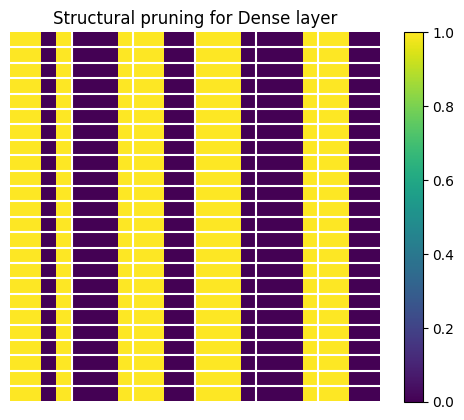

In [15]:
plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Structural pruning for Dense layer")
plt.show()

Visualize weights for the `Conv2D` layer. The structural sparsity is applied in the last channel, similar to the `Dense` layer. Only the second `Conv2D` layer is structurally pruned as pointed out above.

In [16]:
# Get weights of the convolutional layer that has been pruned with 2 by 4 sparsity.
op_details = interpreter._get_ops_details()
op_name = 'CONV_2D'
op_detail = [x for x in op_details if op_name in x["op_name"]]
tensor_data = interpreter.tensor(op_detail[1]["inputs"][1])()
print(f"Shape of the weight tensor is {tensor_data.shape}")

Shape of the weight tensor is (64, 5, 5, 32)


Similar to the weights of  `Dense` layer, the last dimension of the kernel has a (2, 4) structure.

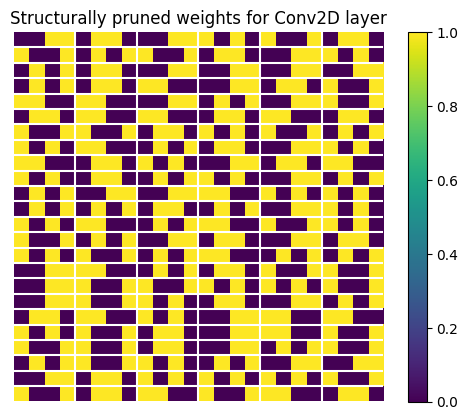

In [17]:
weights_to_display = tf.reshape(tensor_data, [tf.reduce_prod(tensor_data.shape[:-1]), -1])
weights_to_display = weights_to_display[0:width, 0:height]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(weights_to_display) > 1e-9, val_ones, val_zeros)

plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Structurally pruned weights for Conv2D layer")
plt.show()

Let's see how those randomly pruned weights look. We extract them and display a subset of the weight tensor.

In [18]:
# Get weights of the convolutional layer that has been pruned with random pruning.
tensor_name = 'pruning_sparsity_0_5/Conv2D'
detail = [x for x in details if tensor_name in x["name"]]
tensor_data = interpreter.tensor(detail[0]["index"])()
print(f"Shape of the weight tensor is {tensor_data.shape}")

Shape of the weight tensor is (32, 5, 5, 1)


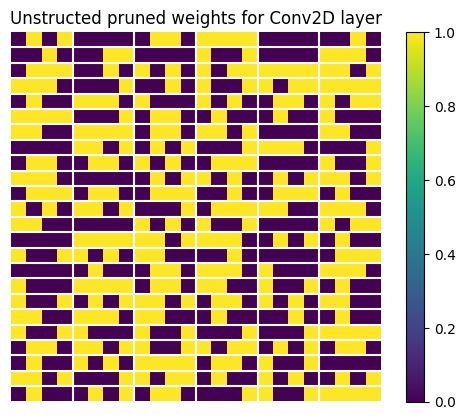

In [19]:
weights_to_display = tf.reshape(tensor_data, [tensor_data.shape[0],tf.reduce_prod(tensor_data.shape[1:])])
weights_to_display = weights_to_display[0:width, 0:height]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(weights_to_display) > 0, val_ones, val_zeros)

plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Unstructed pruned weights for Conv2D layer")
plt.show()

The TensorFlow Model Optimization Toolkit includes a python script that can be used to check whether which layers in the model from the given tflite file have the structurally pruned weights: [`check_sparsity_m_by_n.py`](https://github.com/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/python/core/sparsity/keras/tools/check_sparsity_m_by_n.py). The following command demonstrates how to use this tool to check for 2 by 4 sparsity in a specific model.

In [20]:
! python3 ./tensorflow_model_optimization/python/core/sparsity/keras/tools/check_sparsity_m_by_n.py --model_tflite=pruned_model.tflite --m_by_n=2,4


python3: can't open file '/tmpfs/src/temp/tensorflow_model_optimization/g3doc/guide/pruning/./tensorflow_model_optimization/python/core/sparsity/keras/tools/check_sparsity_m_by_n.py': [Errno 2] No such file or directory
